# Imports & setup

### Imports - general

In [1]:
import os
import re

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import f1_score

In [2]:
from create_Tatoeba_train_test import get_language_mappings, get_sentence_word_char_len

### Imports & setup - langid

In [3]:
from langid.langid import LanguageIdentifier, model

In [4]:
lang_identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)

### Imports & setup - langdetect

In [5]:
from langdetect import DetectorFactory, detect_langs
DetectorFactory.seed = 7

In [6]:
def get_langdetect_prediction(this_string: str):
    """
    Run langdetect on a sentence and get the results.
    
    Args:
    this_string - str; the sentence to run through langdetect.
    
    Returns:
    result - langdetect.language.Language; the langdetect output.
    """
    assert isinstance(this_string, str), "this_string is not of type str."
    
    result = None
    if len(this_string)>0:
        try:
            result = detect_langs(this_string)[0]
        except:
            result = "Error"
            print(f"Error processing sentence: {this_string}")
    return result

def get_langdetect_lang(this_result):
    """
    Get the language-component from the langdetect results.
    
    Args:
    this_result - langdetect.language.Language; the langdetect output.
    
    Returns:
    result - str; 2-character identifier for the predicted language.
    """
    result = "!!"
    if this_result:
        try:
            result = this_result.lang
            result = result.split("-")[0] # mainly for zh-cn
        except:
            pass
    return result

def get_langdetect_prob(this_result):
    """
    Get the probability-component from the langdetect results.
    
    Args:
    this_result - langdetect.language.Language; the langdetect output.
    
    Returns:
    result - float; the probability for the predicted language.
    """
    result = 0.0
    if this_result:
        try:
            result = this_result.prob
        except:
            pass
    return result

In [7]:
language_mappings = get_language_mappings("language_mappings.csv")
iso_639_2_English = language_mappings[["ISO 639-2", "English Name"]].set_index(keys="ISO 639-2")["English Name"].to_dict()
iso_639_2_iso_639_1 = language_mappings[["ISO 639-2", "ISO 639-1"]].set_index(keys="ISO 639-2")["ISO 639-1"].to_dict()

In [8]:
bin_labels = ["1","2","3","4","5","6","7","8","9","10","11 to 16", "17 to 27", "28 to 48", "49 to 99"]
counter = 0
results = []

# Get predictions & calculate F1 scores

In [9]:
# %%time
# 11min for 2 samples
for root, dirs, file in os.walk("output/"):
    if root == "output/":
        for i in file:
            train_sample = re.search(r"train", i)
            if train_sample:
                counter += 1
                print(f"Processing - file:{counter} - {i}")
                sample = pd.read_csv(f"output/{i}")
                sample["Language_English_Name"] = sample["Language"].map(iso_639_2_English)
                sample["Sentence_len"] = sample.apply(lambda row: get_sentence_word_char_len(row), axis=1)
                
                sample["Sentence_len_bin"] = pd.cut(
                    x=sample["Sentence_len"],
                    bins=[0,1,2,3,4,5,6,7,8,9,10,16,27,48,99],
                    labels=bin_labels
                )
                
                ### LANGID ###
                ##############
                
                # find all languages to include in langid predictions
#                 set_languages = [iso_639_2_iso_639_1[i] for i in sample["Language"].unique().tolist()]
#                 lang_identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
                sample["langid"] = sample.apply(lambda row: list(lang_identifier.classify(row["Sentence"])), axis=1)
                sample["langid_language"], sample["langid_score"] = sample["langid"].str
                sample.drop(columns=["langid"], inplace=True)
                # map Language to English Name & langid_language to English Name
                ISO_639_2 = language_mappings.set_index("ISO 639-2")
                ISO_639_2 = ISO_639_2["English Name"].to_dict()
                sample["Language_English_Name"] = sample["Language"].map(ISO_639_2)

                ISO_639_1 = language_mappings.set_index("ISO 639-1")
                ISO_639_1 = ISO_639_1["English Name"].to_dict()
                sample["langid_language_English_Name"] = sample["langid_language"].map(ISO_639_1)
                
                ### LANGDETECT ###
                ##################
                
                sample["langdetect"] = sample.apply(lambda row: get_langdetect_prediction(row["Sentence"]), axis=1)
                sample["langdetect_language"] = sample.apply(lambda row: get_langdetect_lang(row["langdetect"]), axis=1)
                sample["langdetect_score"] = sample.apply(lambda row: get_langdetect_prob(row["langdetect"]), axis=1)
                sample.drop(columns=["langdetect"], inplace=True)
                sample["langdetect_language_English_Name"] = sample["langdetect_language"].map(ISO_639_1)
                
                ### Get F1 ###
                ##############
                
                for this_bin in bin_labels:
                    bin_results = sample[sample["Sentence_len_bin"]==this_bin]
                    for lang in bin_results["Language_English_Name"].unique().tolist():
                        these_results = bin_results[(bin_results["Language_English_Name"]==lang)]
                        for prediction in ["langid", "langdetect"]:
                            these_labels = these_results["Language_English_Name"].unique().tolist()
                            this_f1 = f1_score(these_results["Language_English_Name"], these_results[f"{prediction}_language_English_Name"], labels=these_labels, average="weighted")
                            result = (this_bin, lang, prediction, round(this_f1,2))
                            results.append(result)
                
                counter += 1
                print(f"Finished - file:{counter} - len(results):{len(results)}\n")

Processing - file:1 - Tatoeba_stratify_train_2021-8-4_1157.csv
Error processing sentence: 啥？
2 Tatoeba_stratify_train_2021-8-4_1157.csv 336


In [10]:
del file, bin_results, i, lang, prediction, result, root, sample, these_labels, these_results, this_bin, this_f1    

# Visualize results

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
results = pd.DataFrame(data=results, columns=["Bin", "Language", "Source", "F1"])

In [18]:
results_langid = results[results["Source"]=="langid"]
results_langid_pivot = results_langid.pivot_table(values="F1", index="Language", columns="Bin")
results_langid_pivot = results_langid_pivot[bin_labels]
results_langid_pivot.loc["Average"] = results_langid_pivot.mean()
# results_langid_pivot.head()

results_langdetect = results[results["Source"]=="langdetect"]
results_langdetect_pivot = results_langdetect.pivot_table(values="F1", index="Language", columns="Bin")
results_langdetect_pivot = results_langdetect_pivot[bin_labels]
results_langdetect_pivot.loc["Average"] = results_langdetect_pivot.mean()
# results_langdetect_pivot.head()

Bin,1,2,3,4,5,6,7,8,9,10,11 to 16,17 to 27,28 to 48,49 to 99
Language,,,,,,,,,,,,,,
Chinese,0.33,0.78,0.78,0.82,0.84,0.85,0.83,0.79,0.83,0.83,0.82,0.85,0.85,0.96
Danish,0.29,0.68,0.68,0.75,0.81,0.79,0.88,0.89,0.89,0.90,0.92,0.97,0.98,1.00
Dutch,0.33,0.66,0.76,0.86,0.89,0.91,0.93,0.94,0.96,0.96,0.97,0.99,1.00,1.00
English,0.50,0.89,0.81,0.90,0.96,0.96,0.99,0.99,1.00,1.00,1.00,1.00,1.00,1.00
French,0.40,0.79,0.93,0.96,0.97,0.99,1.00,0.99,1.00,1.00,1.00,1.00,1.00,1.00


In [14]:
# create custom colormap for consistent colors
language_cmap = {}
language_cmap["Average"] = (0.8901960784313725, 0.10196078431372549, 0.10980392156862745) # red-orange

language_cmap["Chinese"] = (0.5545098039215688, 0.7564167627835449, 0.8683121876201461) # blue
language_cmap["Japanese"] = (0.21568627450980393, 0.5294117647058824, 0.7542483660130719) # blue
language_cmap["Korean"] = (0.06251441753171857, 0.35750865051903113, 0.6429065743944637) # blue

language_cmap["French"] = (0.5739331026528259, 0.8241753171856978, 0.5606151480199923) # green
language_cmap["Italian"] = (0.21568627450980393, 0.6287581699346405, 0.3333333333333333) # green
language_cmap["Spanish"] = (0.04359861591695502, 0.4648212226066897, 0.20369088811995384) # green
language_cmap["Portuguese"] = (0.7792233756247597, 0.9132333717800846, 0.7518031526336024) # green

language_cmap["English"] = (0.698961937716263, 0.6965013456362938, 0.8372164552095348) # purple
language_cmap["Danish"] = (0.47320261437908495, 0.43267973856209146, 0.6993464052287581) # purple
language_cmap["German"] = (0.3568166089965398, 0.20525951557093425, 0.5856978085351787) # purple
language_cmap["Dutch"] = (0.38, 0.41, 0.8) # purple?

# create custom dash dict for consistent dashes
language_dashes = {}
language_dashes["Average"] = (1, 1)

language_dashes["Chinese"] = (2, 1)
language_dashes["Japanese"] = (4, 3)
language_dashes["Korean"] = (6, 6)

language_dashes["French"] = (2, 1)
language_dashes["Italian"] = (4, 3)
language_dashes["Spanish"] = (6, 6)
language_dashes["Portuguese"] = (8, 12)

language_dashes["English"] = (2, 1)
language_dashes["Danish"] = (4, 3)
language_dashes["German"] = (6, 6)
language_dashes["Dutch"] = (8, 12)

In [15]:
sns.set_style("darkgrid")
title_font = {"fontweight":"bold", "fontsize":14}
label_fonts = {"fontweight":"bold", "fontsize":12}

## Plot averages

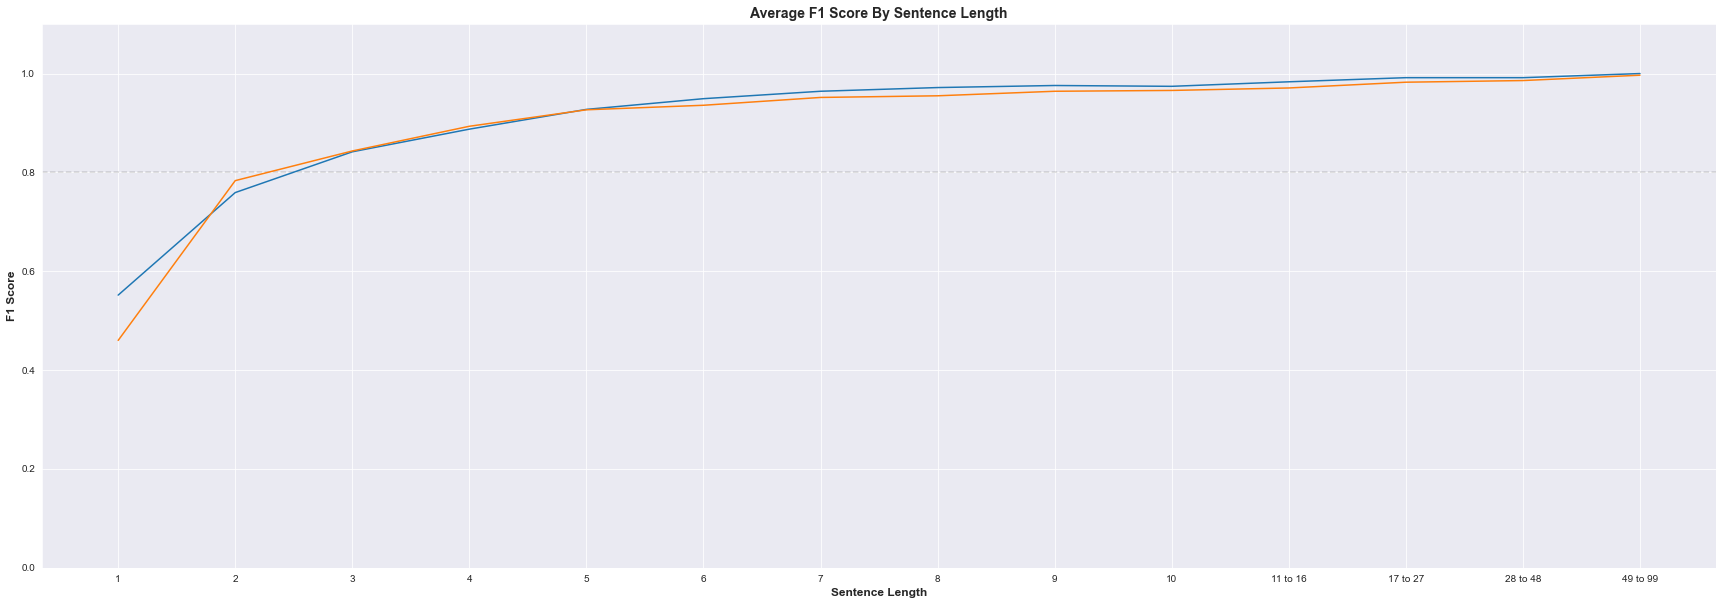

In [17]:
plt.figure(figsize=(30,10))
plt.title("Average F1 Score By Sentence Length", fontdict=title_font)
plt.xlabel("Sentence Length", fontdict=label_fonts)
plt.ylabel("F1 Score", fontdict=label_fonts)
plt.ylim(0.0, 1.1)
plt.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3);
sns.lineplot(data=results_langid_pivot.loc["Average"].T);
sns.lineplot(data=results_langdetect_pivot.loc["Average"].T);
# plt.legend(loc="lower right");